In [2]:
%matplotlib inline

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import scipy.stats as stats

from IPython.display import display
from ipywidgets import *

from pyearth import Earth
from sklearn import cross_validation

In [3]:
import statsmodels.api as sm 
import statsmodels.formula.api as smf

### Utilities

In [4]:
# Regression plot showing predicted gF scores vs original gF scores
def regression_plot(x,y,n,title):

    # fit a curve to the data using a least squares 1st order polynomial fit
    z = np.polyfit(x,y,1)

    p = np.poly1d(z)
    fit = p(x)

    # get the coordinates for the fit curve
    c_x = [np.min(x),np.max(x)]
    c_y = p(c_x)

    # predict y values of origional data using the fit
    p_y = z[0] * x + z[1]

    # calculate the y-error (residuals)
    y_err = y - p_y

    # create series of new test x-values to predict for
    p_x = np.arange(np.min(x),np.max(x)+1,1)

    # now calculate confidence intervals for new test x-series
    mean_x = np.mean(x)         # mean of x
    DF = n - z.size                            # degrees of freedom
    t = stats.t.ppf(0.95,DF)           # used for CI and PI bands
    s_err = np.sum(np.power(y_err,2))   # sum of the squares of the residuals

    #confs = t * np.sqrt((s_err/(n-2))*(1.0/n + (np.power((p_x-mean_x),2)/((np.sum(np.power(x,2)))-n*(np.power(mean_x,2))))))
    confs = t * np.sqrt((s_err/(n-2)) * (1.0/n + (np.power((p_x-mean_x),2)/(np.sum(np.power(x - mean_x,2))))))
    # now predict y based on test x-values
    p_y = z[0]*p_x+z[1]

    # get lower and upper confidence limits based on predicted y and confidence intervals
    lower = p_y - abs(confs)
    upper = p_y + abs(confs)

    # set-up the plot
    plt.subplots(figsize=(8,8))
    plt.axes().set_aspect('equal')
    plt.xlabel('Original score')
    plt.ylabel('Predicted score')
    plt.title(title)

    # plot sample data
    plt.plot(x,y,'bo')

    # plot line of best fit
    plt.plot(c_x,c_y,'r-',label='Regression line')

    # plot confidence limits
    plt.plot(p_x,lower,'b--',label='Lower confidence limit (95%)')
    plt.plot(p_x,upper,'b--',label='Upper confidence limit (95%)')

    # set coordinate limits
    plt.xlim(4,25)
    plt.ylim(5,25)

    # configure legend
    plt.legend(loc=0)
    leg = plt.gca().get_legend()
    ltext = leg.get_texts()
    plt.setp(ltext, fontsize=10)

    # add text
    rho,p = stats.pearsonr(np.ravel(y),x)
    s = 'r={:0.2f}\np={:1.4f}'.format(rho,p)
    plt.text(20, 7, s, fontsize=12)

    # show the plot
    plt.show()
    

### Importing data

In [14]:
#data = sio.loadmat('improved_preproc/rfMRI_REST1_HCP_Q2.mat')
data = sio.loadmat('improved_preproc/rfMRI_REST2_HCP_Q2.mat')
gF = np.ravel(data['PMAT24_A_CR'])
n_subj = len(gF)

### gF score distribution

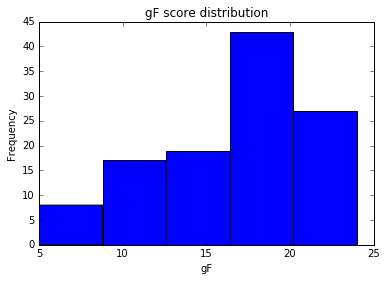

5

In [15]:
# gF score distribution 
n_bins = 5
def plot_hist(n_bins):
    plt.hist(gF, bins=n_bins)
    plt.title("gF score distribution")
    plt.xlabel("gF")
    plt.ylabel("Frequency")
    plt.show()
    return n_bins
    
interact(plot_hist, n_bins=(5,50,5)) 

In [16]:
# needed for stratified k-fold
hist, bin_limits = np.histogram(gF, n_bins)
bins = np.digitize(gF, bin_limits)
print(bin_limits)

[  5.    8.8  12.6  16.4  20.2  24. ]


### Building input matrix

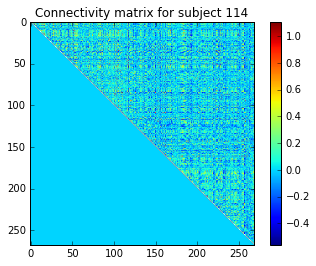

In [17]:
# choose dataset
#conn_mats = data['rest_1_mat']
conn_mats = data['rest_2_mat']


# build matrix n_subjects x n_edges
n_parcels = conn_mats.shape[0]
triu_idx = np.triu_indices(n_parcels,1)
n_edges = len(triu_idx[1]);

def plt_conn(subject):
    plt.imshow(np.triu(conn_mats[:,:,subject-1]))
    plt.colorbar()
    plt.title('Connectivity matrix for subject '+str(subject))

interact(plt_conn, subject=(1,n_subj),continuous_update=False)    
    
edges = np.zeros([n_subj,n_edges])

for subject in range(conn_mats.shape[-1]):
    edges[subject,] = conn_mats[:,:,subject][triu_idx]

### Training/Test Split
In order to build an holdout set that preserves the distribution of the gF scores across subjects, the scores are divided in bins and then a stratified split is performed.  

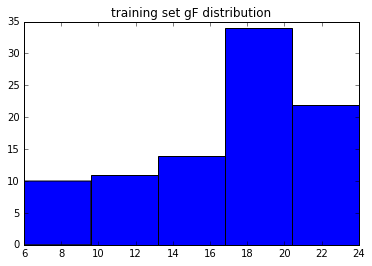

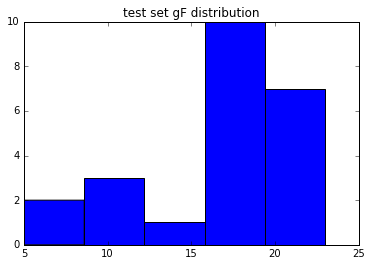

In [18]:
# Hold out set
X_train, X_test, y_train, y_test = cross_validation.train_test_split(edges,gF,test_size=0.2, random_state=42, stratify=bins)
plt.hist(y_train, bins=n_bins)
plt.title('training set gF distribution')
plt.show()
plt.hist(y_test, bins=n_bins)
plt.title('test set gF distribution')
plt.show()

### Test

In [19]:
model = Earth(verbose=2)
model.fit(X_train,y_train)

print(model.trace())
print(model.summary)

y_hat = model.predict(X_test)


Beginning forward pass
-----------------------------------------------------------------
iter  parent  var  knot  mse        terms  gcv     rsq    grsq   
-----------------------------------------------------------------
0     -       -    -     21.851950  1      22.340  0.000  0.000  
1     0       30551  6     16.507408  3      18.920  0.245  0.153  
2     0       2131  19    12.734406  5      16.477  0.417  0.262  
3     0       9572  71    9.449839  7      13.912  0.568  0.377  
4     0       31911  46    7.288990  9      12.318  0.666  0.449  
5     0       10842  25    5.362489  11     10.510  0.755  0.530  
6     0       26375  33    4.168323  13     9.588  0.809  0.571  
7     0       6730  11    3.330728  15     9.118  0.848  0.592  
8     0       26477  5     2.598463  17     8.607  0.881  0.615  
9     0       8113  66    1.920214  19     7.852  0.912  0.649  
10    0       28849  29    1.376832  21     7.126  0.937  0.681  
11    0       14680  88    1.020910  23     6.901 

In [12]:
results = {'mars_improved':y_hat, 'score':y_test}
sio.savemat('res_mars_improved_1.mat', results)

In [20]:
results = {'mars_improved':y_hat, 'score':y_test}
sio.savemat('res_mars_improved_2.mat', results)

### Plots Rest Session 1

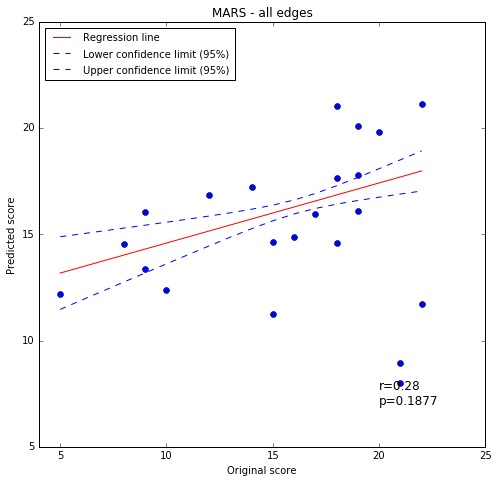

In [11]:
regression_plot(np.ravel(y_test),np.ravel(y_hat),n_subj,'MARS - all edges') 

In [13]:
print(y_hat)

[ 20.08840689  19.81981489  17.64359249   8.95149277  17.21263225
  12.17260728  14.85545367  16.05473488  11.22835997  16.1160465
  25.64353007   7.99154111  16.84921417  14.65131276  21.13573115
  29.78928561  14.57846498  15.96336371  12.39307578  13.36696399
  21.05095089  11.71340362  14.52658792  17.80302977]


### Plots Rest Session 2

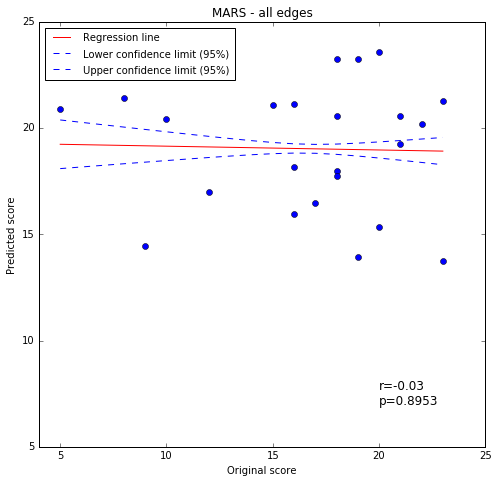

In [21]:
regression_plot(np.ravel(y_test),np.ravel(y_hat),n_subj,'MARS - all edges') 

In [22]:
print(y_hat)

[ 21.10725734  15.96598164  16.47663175  16.97582391  17.99643047
  23.24151677  13.94831005  20.20684943  17.75063329  20.87465681
  13.76121817  21.0717897   18.15112705  20.54060149  23.24575852
  21.25761938  15.31998842  20.55819571  19.24412006  14.43101404
  23.59373789  20.40810908  21.39241467]
